In [2]:
import h5py
import numpy as np

path = "../Data/simulation_data.h5"

def load_groups_with_pressure_proxy(path):
    records = []
    with h5py.File(path, "r") as f:
        groups = sorted(list(f.keys()))
        for gname in groups:
            g = f[gname]
            X = np.asarray(g["mesh_pos"][:], dtype=np.float32)          # (N,3)
            d = np.asarray(g["deformation"][:], dtype=np.float32)       # (N,)  (|u_y| or u_y>=0)
            vm = np.asarray(g["eq_stress"][:], dtype=np.float32)        # (N,)
            cells = np.asarray(g["cells"][:], dtype=np.int64)           # (M,8)

            # load/pressure proxy for this simulation case
            p_proxy = float(d.max())  # scalar per group

            records.append({
                "group": gname,
                "X": X,
                "d": d,
                "vm": vm,
                "cells": cells,
                "p_proxy": p_proxy,
            })
    return records

data = load_groups_with_pressure_proxy(path)

print("Loaded groups:", len(data))
print("Example group:", data[0]["group"])
print("Shapes: X", data[0]["X"].shape, "| d", data[0]["d"].shape, "| vm", data[0]["vm"].shape, "| cells", data[0]["cells"].shape)
print("p_proxy example:", data[0]["p_proxy"])


Loaded groups: 20
Example group: group_01
Shapes: X (3872, 3) | d (3872,) | vm (3872,) | cells (1845, 8)
p_proxy example: 1.0359000270909746e-06


In [3]:
#if proxy makes sense (does it vary across groups?)

pvals = np.array([r["p_proxy"] for r in data], dtype=np.float64)
print("p_proxy min/max:", pvals.min(), pvals.max())
print("p_proxy values (sorted):")
print(np.sort(pvals))


p_proxy min/max: 1.0359000270909746e-06 2.1558998923865147e-06
p_proxy values (sorted):
[1.03590003e-06 1.06640005e-06 1.09650000e-06 1.12789996e-06
 1.16110004e-06 1.19890001e-06 1.22819995e-06 1.27600003e-06
 1.32219998e-06 1.36230005e-06 1.41359999e-06 1.47250000e-06
 1.53780002e-06 1.60130003e-06 1.66710004e-06 1.76339995e-06
 1.84650003e-06 1.94850008e-06 2.05419997e-06 2.15589989e-06]


corr(p_proxy, max_vm) = 0.9789999593863326


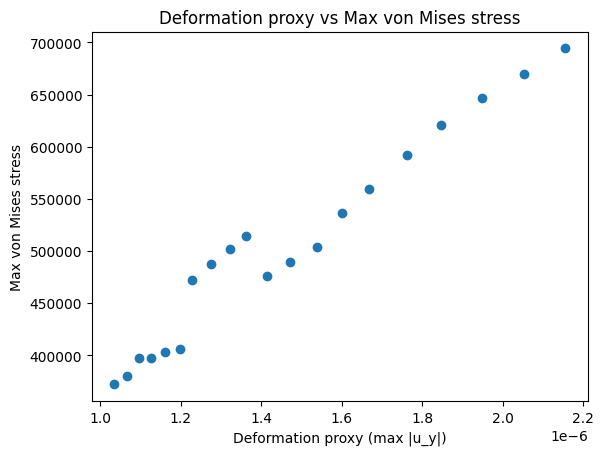

In [4]:
# quick check if higher proxy means higher stress values
import matplotlib.pyplot as plt

pairs = []
for r in data:
    pairs.append((r["p_proxy"], float(r["vm"].max())))
pairs = np.array(pairs)

# Sort by deformation proxy
pairs = pairs[np.argsort(pairs[:,0])]

# Correlation (should be strongly positive)
corr = np.corrcoef(pairs[:,0], pairs[:,1])[0,1]
print("corr(p_proxy, max_vm) =", corr)

# Scatter plot
plt.scatter(pairs[:,0], pairs[:,1]) 
plt.xlabel("Deformation proxy (max |u_y|)")
plt.ylabel("Max von Mises stress")
plt.title("Deformation proxy vs Max von Mises stress")
plt.show()



In [5]:
import numpy as np

# Stack everything to compute global scales
X_all = np.vstack([r["X"] for r in data])             # (sum N, 3)
vm_all = np.hstack([r["vm"] for r in data])           # (sum N,)
p_all = np.array([r["p_proxy"] for r in data])        # (num_groups,)

# Coordinate normalization to [-1,1]
x_min = X_all.min(axis=0)
x_max = X_all.max(axis=0)
x_scale = x_max - x_min
x_scale[x_scale == 0] = 1.0

def normalize_X(X):
    return 2.0 * (X - x_min) / x_scale - 1.0

# Pressure proxy normalization to [0,1]
p_min, p_max = p_all.min(), p_all.max()
p_scale = p_max - p_min

def normalize_p(p):
    return (p - p_min) / p_scale

# Stress normalization (scale only, keep sign)
vm_scale = np.max(vm_all)

def normalize_vm(vm):
    return vm / vm_scale

def denormalize_vm(vm_n):
    return vm_n * vm_scale

print("Scales:")
print("x range:", x_min, x_max)
print("p range:", p_min, p_max)
print("vm scale:", vm_scale)


Scales:
x range: [ 0.        0.       -1.163182] [0.1461 0.2514 0.    ]
p range: 1.0359000270909746e-06 2.1558998923865147e-06
vm scale: 694210.0


In [6]:
X_list = []
Y_list = []

for r in data:
    Xn = normalize_X(r["X"])                           # (N,3)
    p_n = normalize_p(r["p_proxy"])                    # scalar
    p_col = np.full((Xn.shape[0], 1), p_n, dtype=np.float32)

    inp = np.hstack([Xn, p_col])                       # (N,4)
    out = normalize_vm(r["vm"]).reshape(-1, 1)         # (N,1)

    X_list.append(inp)
    Y_list.append(out)

X_train = np.vstack(X_list).astype(np.float32)
Y_train = np.vstack(Y_list).astype(np.float32)

print("Final dataset shapes:")
print("X_train:", X_train.shape)   # (total_nodes, 4)
print("Y_train:", Y_train.shape)   # (total_nodes, 1)


Final dataset shapes:
X_train: (76590, 4)
Y_train: (76590, 1)


In [7]:
print("Input ranges:")
print("x,y,z min:", X_train[:,:3].min(axis=0))
print("x,y,z max:", X_train[:,:3].max(axis=0))
print("p min/max:", X_train[:,3].min(), X_train[:,3].max())

print("Target range (normalized vm):", Y_train.min(), Y_train.max())


Input ranges:
x,y,z min: [-1. -1. -1.]
x,y,z max: [1. 1. 1.]
p min/max: 0.0 1.0
Target range (normalized vm): 0.00068905664 1.0


In [8]:
#defining the baseline network
import torch
import torch.nn as nn

class BaselineMLP(nn.Module):
    def __init__(self, in_dim=4, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.ReLU()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [9]:
device = "cpu"

X_t = torch.tensor(X_train, dtype=torch.float32, device=device)
Y_t = torch.tensor(Y_train, dtype=torch.float32, device=device)

model = BaselineMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print("Training on:", device)


Training on: cpu


In [10]:
#taining the baseline model

batch_size = 4096
epochs = 2000
N = X_t.shape[0]

for ep in range(1, epochs + 1):
    idx = torch.randint(0, N, (batch_size,), device=device)
    xb = X_t[idx]
    yb = Y_t[idx]

    pred = model(xb)
    loss = loss_fn(pred, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0 or ep == 1:
        print(f"ep {ep:4d} | mse {loss.item():.4e}")



ep    1 | mse 9.7797e-01
ep  200 | mse 5.4818e-03
ep  400 | mse 4.6782e-03
ep  600 | mse 3.6047e-03
ep  800 | mse 2.9236e-03
ep 1000 | mse 3.1557e-03
ep 1200 | mse 3.1121e-03
ep 1400 | mse 2.7213e-03
ep 1600 | mse 2.3168e-03
ep 1800 | mse 2.2532e-03
ep 2000 | mse 2.0024e-03


In [11]:
#evaluating on training data

with torch.no_grad():
    pred_all = model(X_t).cpu().numpy().ravel()

true_all = Y_train.ravel()

mse = np.mean((pred_all - true_all) ** 2)
print("Final training MSE (normalized vm):", mse)


Final training MSE (normalized vm): 0.0020633813


In [14]:

import numpy as np
import torch

model.eval()

batch_eval = 65536  # try 32768 if memory is tight
N = X_t.shape[0]

pred_chunks = []
with torch.no_grad():
    for i in range(0, N, batch_eval):
        xb = X_t[i:i+batch_eval]
        pred = model(xb)
        pred_chunks.append(pred.detach().cpu().numpy())

pred_all = np.vstack(pred_chunks).ravel()
true_all = Y_train.ravel()

mse = np.mean((pred_all - true_all)**2)
print("Train MSE (batched):", mse)


Train MSE (batched): 0.0020633813


In [15]:
abs_err = np.abs(pred_all - true_all)
sq_err = (pred_all - true_all) ** 2

print("Mean abs err (normalized):", abs_err.mean())
print("95th percentile abs err:", np.percentile(abs_err, 95))
print("Max abs err:", abs_err.max())


Mean abs err (normalized): 0.028214311
95th percentile abs err: 0.089018084
Max abs err: 0.4563399


In [16]:
# Bin by true stress level
bins = np.linspace(true_all.min(), true_all.max(), 11)
bin_ids = np.digitize(true_all, bins) - 1
bin_ids = np.clip(bin_ids, 0, len(bins)-2)

for b in range(len(bins)-1):
    mask = bin_ids == b
    if mask.sum() == 0:
        continue
    print(
        f"vm in [{bins[b]:.2f},{bins[b+1]:.2f}] "
        f"count={mask.sum():7d} mean_abs_err={abs_err[mask].mean():.4f}"
    )


vm in [0.00,0.10] count=  49433 mean_abs_err=0.0194
vm in [0.10,0.20] count=  19785 mean_abs_err=0.0313
vm in [0.20,0.30] count=   3802 mean_abs_err=0.0631
vm in [0.30,0.40] count=   1592 mean_abs_err=0.0670
vm in [0.40,0.50] count=    836 mean_abs_err=0.0720
vm in [0.50,0.60] count=    530 mean_abs_err=0.1053
vm in [0.60,0.70] count=    336 mean_abs_err=0.1582
vm in [0.70,0.80] count=    172 mean_abs_err=0.2307
vm in [0.80,0.90] count=     78 mean_abs_err=0.2707
vm in [0.90,1.00] count=     26 mean_abs_err=0.3328


In [17]:
p_per_node = []
for r in data:
    p_n = normalize_p(r["p_proxy"])
    p_per_node.append(np.full((r["X"].shape[0],), p_n, dtype=np.float32))
p_per_node = np.hstack(p_per_node)

print("p_per_node shape:", p_per_node.shape)

# Bin by p
pbins = np.linspace(0, 1, 6)
pid = np.digitize(p_per_node, pbins) - 1
pid = np.clip(pid, 0, len(pbins)-2)

for b in range(len(pbins)-1):
    mask = pid == b
    print(
        f"p in [{pbins[b]:.2f},{pbins[b+1]:.2f}] "
        f"count={mask.sum():7d} mean_abs_err={abs_err[mask].mean():.4f}"
    )


p_per_node shape: (76590,)
p in [0.00,0.20] count=  27118 mean_abs_err=0.0222
p in [0.20,0.40] count=  18834 mean_abs_err=0.0253
p in [0.40,0.60] count=  11236 mean_abs_err=0.0304
p in [0.60,0.80] count=   7838 mean_abs_err=0.0361
p in [0.80,1.00] count=  11564 mean_abs_err=0.0396


In [18]:
import torch
import torch.nn as nn

class StressPINN(nn.Module):
    def __init__(self, in_dim=4, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 6)]  # σxx, σyy, σzz, σxy, σxz, σyz
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [19]:
def von_mises_from_stress(sig):
    sxx, syy, szz, sxy, sxz, syz = torch.split(sig, 1, dim=1)

    vm = torch.sqrt(
        0.5 * ((sxx - syy)**2 + (syy - szz)**2 + (szz - sxx)**2)
        + 3.0 * (sxy**2 + sxz**2 + syz**2)
    )
    return vm


In [20]:
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True
    )[0]

def equilibrium_residual(x, sig):
    sxx, syy, szz, sxy, sxz, syz = torch.split(sig, 1, dim=1)

    dsxx = grad(sxx, x)
    dsyy = grad(syy, x)
    dszz = grad(szz, x)
    dsxy = grad(sxy, x)
    dsxz = grad(sxz, x)
    dsyz = grad(syz, x)

    rx = dsxx[:, 0:1] + dsxy[:, 1:2] + dsxz[:, 2:3]
    ry = dsxy[:, 0:1] + dsyy[:, 1:2] + dsyz[:, 2:3]
    rz = dsxz[:, 0:1] + dsyz[:, 1:2] + dszz[:, 2:3]

    return torch.cat([rx, ry, rz], dim=1)


In [21]:
import torch
import torch.nn as nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

X_t = torch.tensor(X_train, dtype=torch.float32, device=device)
Y_t = torch.tensor(Y_train, dtype=torch.float32, device=device)

pinn = StressPINN(in_dim=4).to(device)
opt = torch.optim.Adam(pinn.parameters(), lr=1e-3)

print("Device:", device, "N samples:", X_t.shape[0])


Device: cpu N samples: 76590


In [22]:
mse = nn.MSELoss()

def pinn_loss(pinn, xb, yb, w_data=1.0, w_phys=0.0):
    # xb must require grad for physics
    xb = xb.clone().detach().requires_grad_(True)

    sig = pinn(xb)                      # (B,6)
    vm_pred = von_mises_from_stress(sig) # (B,1)

    loss_data = mse(vm_pred, yb)

    if w_phys > 0:
        r = equilibrium_residual(xb, sig)   # (B,3)
        loss_phys = torch.mean(r**2)
    else:
        loss_phys = torch.tensor(0.0, device=xb.device)

    loss = w_data * loss_data + w_phys * loss_phys
    return loss, loss_data.detach(), loss_phys.detach()


In [23]:
batch_size = 4096
epochs_A = 1200
N = X_t.shape[0]

for ep in range(1, epochs_A + 1):
    idx = torch.randint(0, N, (batch_size,), device=device)
    xb = X_t[idx]
    yb = Y_t[idx]

    loss, ld, lp = pinn_loss(pinn, xb, yb, w_data=1.0, w_phys=0.0)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if ep % 200 == 0 or ep == 1:
        print(f"[A] ep {ep:4d} | data {ld.item():.4e} | phys {lp.item():.4e} | total {loss.item():.4e}")


[A] ep    1 | data 1.9664e-01 | phys 0.0000e+00 | total 1.9664e-01
[A] ep  200 | data 8.5961e-03 | phys 0.0000e+00 | total 8.5961e-03
[A] ep  400 | data 4.5823e-03 | phys 0.0000e+00 | total 4.5823e-03
[A] ep  600 | data 4.7314e-03 | phys 0.0000e+00 | total 4.7314e-03
[A] ep  800 | data 4.4994e-03 | phys 0.0000e+00 | total 4.4994e-03
[A] ep 1000 | data 4.3654e-03 | phys 0.0000e+00 | total 4.3654e-03
[A] ep 1200 | data 4.0779e-03 | phys 0.0000e+00 | total 4.0779e-03


In [24]:
epochs_B = 2000

w_phys_start = 1e-6
w_phys_end   = 1e-4

for ep in range(1, epochs_B + 1):
    # linear ramp
    t = (ep - 1) / max(1, epochs_B - 1)
    w_phys = (1 - t) * w_phys_start + t * w_phys_end

    idx = torch.randint(0, N, (batch_size,), device=device)
    xb = X_t[idx]
    yb = Y_t[idx]

    loss, ld, lp = pinn_loss(pinn, xb, yb, w_data=1.0, w_phys=w_phys)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if ep % 200 == 0 or ep == 1:
        print(f"[B] ep {ep:4d} | w_phys {w_phys:.1e} | data {ld.item():.4e} | phys {lp.item():.4e} | total {loss.item():.4e}")


[B] ep    1 | w_phys 1.0e-06 | data 4.3988e-03 | phys 2.8592e-02 | total 4.3989e-03
[B] ep  200 | w_phys 1.1e-05 | data 4.7074e-03 | phys 1.5958e-02 | total 4.7076e-03
[B] ep  400 | w_phys 2.1e-05 | data 4.0334e-03 | phys 2.8422e-02 | total 4.0340e-03
[B] ep  600 | w_phys 3.1e-05 | data 4.5622e-03 | phys 2.8672e-02 | total 4.5631e-03
[B] ep  800 | w_phys 4.1e-05 | data 4.5494e-03 | phys 2.8263e-02 | total 4.5506e-03
[B] ep 1000 | w_phys 5.0e-05 | data 3.6733e-03 | phys 2.9104e-02 | total 3.6748e-03
[B] ep 1200 | w_phys 6.0e-05 | data 4.1075e-03 | phys 2.7237e-02 | total 4.1092e-03
[B] ep 1400 | w_phys 7.0e-05 | data 4.6684e-03 | phys 2.7469e-02 | total 4.6703e-03
[B] ep 1600 | w_phys 8.0e-05 | data 4.1114e-03 | phys 2.6067e-02 | total 4.1135e-03
[B] ep 1800 | w_phys 9.0e-05 | data 4.2692e-03 | phys 2.7508e-02 | total 4.2717e-03
[B] ep 2000 | w_phys 1.0e-04 | data 4.6530e-03 | phys 2.5856e-02 | total 4.6556e-03


In [27]:
pinn.eval()

batch_eval = 65536
N = X_t.shape[0]

pred_chunks = []
with torch.no_grad():
    for i in range(0, N, batch_eval):
        xb = X_t[i:i+batch_eval]
        sig = pinn(xb)
        vm_pred = von_mises_from_stress(sig)
        pred_chunks.append(vm_pred.cpu().numpy())

pinn_pred = np.vstack(pred_chunks).ravel()
true_all = Y_train.ravel()

mse_pinn = np.mean((pinn_pred - true_all)**2)
mae_pinn = np.mean(np.abs(pinn_pred - true_all))

print("PINN Train MSE (normalized vm):", mse_pinn)
print("PINN Train MAE (normalized vm):", mae_pinn)


PINN Train MSE (normalized vm): 0.0042130454
PINN Train MAE (normalized vm): 0.03920951


In [28]:
pinn_abs_err = np.abs(pinn_pred - true_all)
print("PINN Mean abs err:", pinn_abs_err.mean())
print("PINN 95th pct abs err:", np.percentile(pinn_abs_err, 95))
print("PINN Max abs err:", pinn_abs_err.max())


PINN Mean abs err: 0.03920951
PINN 95th pct abs err: 0.13089775
PINN Max abs err: 0.6463649


In [29]:
bins = np.linspace(true_all.min(), true_all.max(), 11)
bin_ids = np.digitize(true_all, bins) - 1
bin_ids = np.clip(bin_ids, 0, len(bins)-2)

for b in range(len(bins)-1):
    mask = bin_ids == b
    if mask.sum() == 0:
        continue
    print(
        f"vm in [{bins[b]:.2f},{bins[b+1]:.2f}] "
        f"count={mask.sum():7d} "
        f"baseline_mean_abs_err={abs_err[mask].mean():.4f} "
        f"pinn_mean_abs_err={pinn_abs_err[mask].mean():.4f}"
    )


vm in [0.00,0.10] count=  49433 baseline_mean_abs_err=0.0194 pinn_mean_abs_err=0.0249
vm in [0.10,0.20] count=  19785 baseline_mean_abs_err=0.0313 pinn_mean_abs_err=0.0456
vm in [0.20,0.30] count=   3802 baseline_mean_abs_err=0.0631 pinn_mean_abs_err=0.0666
vm in [0.30,0.40] count=   1592 baseline_mean_abs_err=0.0670 pinn_mean_abs_err=0.0917
vm in [0.40,0.50] count=    836 baseline_mean_abs_err=0.0720 pinn_mean_abs_err=0.1480
vm in [0.50,0.60] count=    530 baseline_mean_abs_err=0.1053 pinn_mean_abs_err=0.2302
vm in [0.60,0.70] count=    336 baseline_mean_abs_err=0.1582 pinn_mean_abs_err=0.3053
vm in [0.70,0.80] count=    172 baseline_mean_abs_err=0.2307 pinn_mean_abs_err=0.3979
vm in [0.80,0.90] count=     78 baseline_mean_abs_err=0.2707 pinn_mean_abs_err=0.4726
vm in [0.90,1.00] count=     26 baseline_mean_abs_err=0.3328 pinn_mean_abs_err=0.5900


In [30]:
pbins = np.linspace(0, 1, 6)
pid = np.digitize(p_per_node, pbins) - 1
pid = np.clip(pid, 0, len(pbins)-2)

for b in range(len(pbins)-1):
    mask = pid == b
    print(
        f"p in [{pbins[b]:.2f},{pbins[b+1]:.2f}] "
        f"count={mask.sum():7d} "
        f"baseline_mean_abs_err={abs_err[mask].mean():.4f} "
        f"pinn_mean_abs_err={pinn_abs_err[mask].mean():.4f}"
    )


p in [0.00,0.20] count=  27118 baseline_mean_abs_err=0.0222 pinn_mean_abs_err=0.0329
p in [0.20,0.40] count=  18834 baseline_mean_abs_err=0.0253 pinn_mean_abs_err=0.0349
p in [0.40,0.60] count=  11236 baseline_mean_abs_err=0.0304 pinn_mean_abs_err=0.0398
p in [0.60,0.80] count=   7838 baseline_mean_abs_err=0.0361 pinn_mean_abs_err=0.0473
p in [0.80,1.00] count=  11564 baseline_mean_abs_err=0.0396 pinn_mean_abs_err=0.0550


In [31]:
pinn.train()  # residual needs grads

B = 8192
idx = torch.randint(0, X_t.shape[0], (B,), device=device)
xb = X_t[idx].clone().detach().requires_grad_(True)

sig = pinn(xb)
r = equilibrium_residual(xb, sig)   # (B,3)
r_norm = torch.sqrt(torch.sum(r**2, dim=1))  # (B,)

print("Residual |r| mean:", float(r_norm.mean().detach().cpu()))
print("Residual |r| 95th:", float(torch.quantile(r_norm, 0.95).detach().cpu()))


Residual |r| mean: 0.2594643533229828
Residual |r| 95th: 0.4171682298183441


In [32]:
def weighted_mse(pred, target, alpha=10.0, k=2.0):
    # target is normalized von Mises in [0,1]
    w = 1.0 + alpha * (target ** k)
    return torch.mean(w * (pred - target) ** 2)


In [33]:
def pinn_loss_weighted(pinn, xb, yb, w_data=1.0, w_phys=0.0, alpha=10.0, k=2.0):
    xb = xb.clone().detach().requires_grad_(True)

    sig = pinn(xb)
    vm_pred = von_mises_from_stress(sig)

    loss_data = weighted_mse(vm_pred, yb, alpha=alpha, k=k)

    if w_phys > 0:
        r = equilibrium_residual(xb, sig)
        loss_phys = torch.mean(r**2)
    else:
        loss_phys = torch.tensor(0.0, device=xb.device)

    loss = w_data * loss_data + w_phys * loss_phys
    return loss, loss_data.detach(), loss_phys.detach()


In [35]:
pinn2 = StressPINN(in_dim=4).to(device)
opt2 = torch.optim.Adam(pinn2.parameters(), lr=1e-3)

batch_size = 4096
N = X_t.shape[0]

# Stage A (weighted data only)
for ep in range(1, 601):
    idx = torch.randint(0, N, (batch_size,), device=device)
    xb = X_t[idx]
    yb = Y_t[idx]

    loss, ld, lp = pinn_loss_weighted(pinn2, xb, yb, w_data=1.0, w_phys=0.0, alpha=10.0, k=2.0)
    opt2.zero_grad()
    loss.backward()
    opt2.step()

    if ep % 200 == 0 or ep == 1:
        print(f"[A-w] ep {ep:4d} | data {ld.item():.4e} | total {loss.item():.4e}")

# Stage B (add small physics)
for ep in range(1, 601):
    t = (ep - 1) / 599
    w_phys = 1e-6 + t * (1e-5 - 1e-6)

    idx = torch.randint(0, N, (batch_size,), device=device)
    xb = X_t[idx]
    yb = Y_t[idx]

    loss, ld, lp = pinn_loss_weighted(pinn2, xb, yb, w_data=1.0, w_phys=w_phys, alpha=10.0, k=2.0)
    opt2.zero_grad()
    loss.backward()
    opt2.step()

    if ep % 200 == 0 or ep == 1:
        print(f"[B-w] ep {ep:4d} | w_phys {w_phys:.1e} | data {ld.item():.4e} | phys {lp.item():.4e} | total {loss.item():.4e}")


[A-w] ep    1 | data 3.2511e-01 | total 3.2511e-01
[A-w] ep  200 | data 1.9211e-02 | total 1.9211e-02
[A-w] ep  400 | data 1.2962e-02 | total 1.2962e-02
[A-w] ep  600 | data 1.1633e-02 | total 1.1633e-02
[B-w] ep    1 | w_phys 1.0e-06 | data 1.3764e-02 | phys 1.9885e-02 | total 1.3764e-02
[B-w] ep  200 | w_phys 4.0e-06 | data 1.1899e-02 | phys 1.9757e-02 | total 1.1899e-02
[B-w] ep  400 | w_phys 7.0e-06 | data 2.4016e-02 | phys 1.9970e-02 | total 2.4016e-02
[B-w] ep  600 | w_phys 1.0e-05 | data 1.0782e-02 | phys 2.0150e-02 | total 1.0782e-02


In [36]:
pinn2.eval()
batch_eval = 65536
N = X_t.shape[0]

pred_chunks = []
with torch.no_grad():
    for i in range(0, N, batch_eval):
        xb = X_t[i:i+batch_eval]
        sig = pinn2(xb)
        vm_pred = von_mises_from_stress(sig)
        pred_chunks.append(vm_pred.cpu().numpy())

pinn2_pred = np.vstack(pred_chunks).ravel()
pinn2_abs_err = np.abs(pinn2_pred - true_all)

print("pinn2 MSE:", np.mean((pinn2_pred - true_all)**2))
print("pinn2 MAE:", np.mean(pinn2_abs_err))


pinn2 MSE: 0.0054609464
pinn2 MAE: 0.049796987


In [37]:
bins = np.linspace(true_all.min(), true_all.max(), 11)
bin_ids = np.digitize(true_all, bins) - 1
bin_ids = np.clip(bin_ids, 0, len(bins)-2)

for b in range(len(bins)-1):
    mask = bin_ids == b
    if mask.sum() == 0:
        continue
    print(
        f"vm in [{bins[b]:.2f},{bins[b+1]:.2f}] "
        f"count={mask.sum():7d} "
        f"baseline={abs_err[mask].mean():.4f} "
        f"pinn2={pinn2_abs_err[mask].mean():.4f}"
    )


vm in [0.00,0.10] count=  49433 baseline=0.0194 pinn2=0.0392
vm in [0.10,0.20] count=  19785 baseline=0.0313 pinn2=0.0516
vm in [0.20,0.30] count=   3802 baseline=0.0631 pinn2=0.0896
vm in [0.30,0.40] count=   1592 baseline=0.0670 pinn2=0.0928
vm in [0.40,0.50] count=    836 baseline=0.0720 pinn2=0.1214
vm in [0.50,0.60] count=    530 baseline=0.1053 pinn2=0.1790
vm in [0.60,0.70] count=    336 baseline=0.1582 pinn2=0.2277
vm in [0.70,0.80] count=    172 baseline=0.2307 pinn2=0.3109
vm in [0.80,0.90] count=     78 baseline=0.2707 pinn2=0.3646
vm in [0.90,1.00] count=     26 baseline=0.3328 pinn2=0.4792


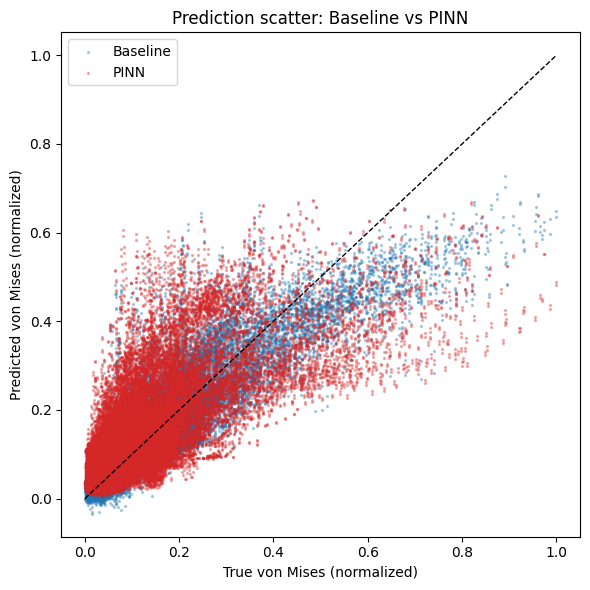

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(true_all, pred_all, s=2, alpha=0.3, label="Baseline", color="tab:blue")
plt.scatter(true_all, pinn2_pred, s=2, alpha=0.3, label="PINN", color="tab:red")
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel("True von Mises (normalized)")
plt.ylabel("Predicted von Mises (normalized)")
plt.legend()
plt.title("Prediction scatter: Baseline vs PINN")
plt.tight_layout()
plt.show()


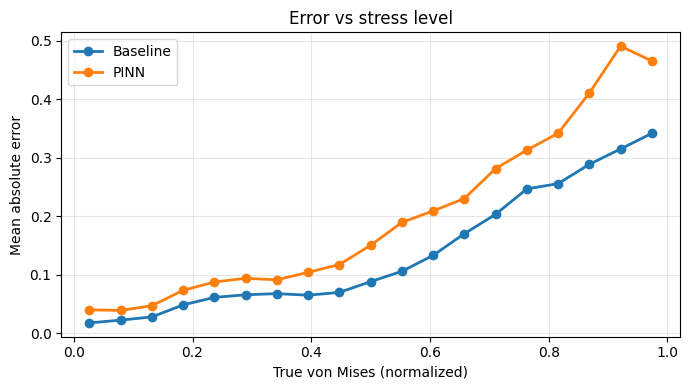

In [39]:
bins = np.linspace(0, 1, 20)
centers = 0.5 * (bins[:-1] + bins[1:])

baseline_err_curve = []
pinn_err_curve = []

for i in range(len(bins)-1):
    mask = (true_all >= bins[i]) & (true_all < bins[i+1])
    if mask.sum() == 0:
        baseline_err_curve.append(np.nan)
        pinn_err_curve.append(np.nan)
    else:
        baseline_err_curve.append(abs_err[mask].mean())
        pinn_err_curve.append(pinn2_abs_err[mask].mean())

plt.figure(figsize=(7,4))
plt.plot(centers, baseline_err_curve, '-o', label="Baseline", linewidth=2)
plt.plot(centers, pinn_err_curve, '-o', label="PINN", linewidth=2)
plt.xlabel("True von Mises (normalized)")
plt.ylabel("Mean absolute error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Error vs stress level")
plt.tight_layout()
plt.show()


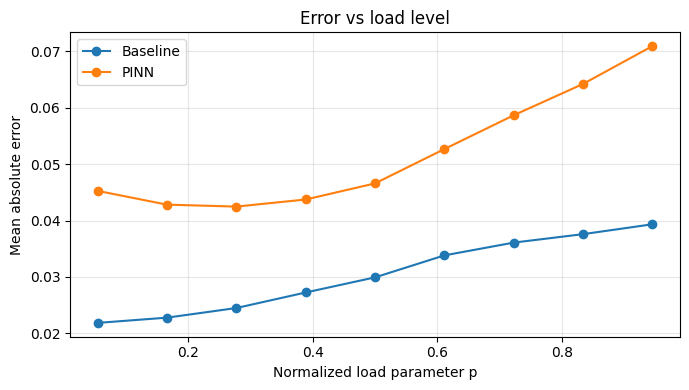

In [40]:
pbins = np.linspace(0, 1, 10)
pcenters = 0.5 * (pbins[:-1] + pbins[1:])

base_p = []
pinn_p = []

for i in range(len(pbins)-1):
    mask = (p_per_node >= pbins[i]) & (p_per_node < pbins[i+1])
    if mask.sum() == 0:
        base_p.append(np.nan)
        pinn_p.append(np.nan)
    else:
        base_p.append(abs_err[mask].mean())
        pinn_p.append(pinn2_abs_err[mask].mean())

plt.figure(figsize=(7,4))
plt.plot(pcenters, base_p, '-o', label="Baseline")
plt.plot(pcenters, pinn_p, '-o', label="PINN")
plt.xlabel("Normalized load parameter p")
plt.ylabel("Mean absolute error")
plt.legend()
plt.grid(True, alpha=0.3)
plt.title("Error vs load level")
plt.tight_layout()
plt.show()
